In [2]:
# Import necessary libraries
import os
import boto3
import re
import copy
import time
import io
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import MinMaxScaler
import sagemaker
from sagemaker import get_execution_role
from sagemaker.image_uris import retrieve
from sagemaker.serializers import CSVSerializer


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [3]:
# Load the dataset
data = load_breast_cancer()

# Create a dataframe
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target


In [4]:
df['target']

0      0
1      0
2      0
3      0
4      0
      ..
564    0
565    0
566    0
567    0
568    1
Name: target, Length: 569, dtype: int64

In [5]:
# Preprocess the data
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df.iloc[:, :-1]), columns=data.feature_names)
df_scaled['target'] = df['target']


In [6]:
# Split the data into training and testing sets
train_data, test_data = train_test_split(df_scaled, test_size=0.2, random_state=23)


In [7]:
# Define the Logistic Regression model
container = retrieve('linear-learner', boto3.Session().region_name)
role = get_execution_role()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [8]:
container

'382416733822.dkr.ecr.us-east-1.amazonaws.com/linear-learner:1'

In [9]:
role

'arn:aws:iam::507163262611:role/CFN-SM-IM-Lambda-Catalog-SageMakerExecutionRole-Qyz1MHBPnXi8'

In [10]:
# Create an output path
bucket = sagemaker.Session().default_bucket()
prefix = 'sagemaker/breast-cancer-prediction'
output_path = 's3://{}/{}/output'.format(bucket, prefix)


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [11]:
# Create a SageMaker session
sess = sagemaker.Session()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [12]:
# Set up the LinearLearner Estimator object
linear = sagemaker.estimator.Estimator(container,
                                       role, 
                                       instance_count=1, 
                                       instance_type='ml.m4.xlarge',
                                       output_path=output_path,
                                       sagemaker_session=sess)


In [13]:
# Set the hyperparameters
linear.set_hyperparameters(feature_dim=train_data.shape[1] - 1,
                           predictor_type='binary_classifier',
                           mini_batch_size=200)


In [17]:
import io
import sagemaker.amazon.common as smac

# Convert the training data into the format required by the SageMaker Linear Learner
buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, train_data.drop(['target'], axis=1).values.astype('float32'), train_data['target'].values.astype('float32'))
buf.seek(0)

# Upload the data to S3
key = 'linearlearner'
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', key)).upload_fileobj(buf)
s3_train_data = 's3://{}/{}/train/{}'.format(bucket, prefix, key)
print('Uploaded training data location: {}'.format(s3_train_data))

# Set the content type and training input locations
s3_input_train = sagemaker.inputs.TrainingInput(s3_data=s3_train_data, content_type='application/x-recordio-protobuf')

# Train the model
linear.fit({'train': s3_input_train})

INFO:sagemaker:Creating training-job with name: linear-learner-2023-12-22-20-44-44-343


Uploaded training data location: s3://sagemaker-us-east-1-507163262611/sagemaker/breast-cancer-prediction/train/linearlearner
2023-12-22 20:44:44 Starting - Starting the training job...
2023-12-22 20:45:09 Starting - Preparing the instances for training.........
2023-12-22 20:46:37 Downloading - Downloading input data...
2023-12-22 20:47:06 Downloading - Downloading the training image.........
2023-12-22 20:48:17 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[12/22/2023 20:48:40 INFO 140086121092928] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples

In [18]:
# Deploy the model
linear_predictor = linear.deploy(initial_instance_count=1,
                                 instance_type='ml.m4.xlarge')


INFO:sagemaker:Creating model with name: linear-learner-2023-12-22-20-55-37-156
INFO:sagemaker:Creating endpoint-config with name linear-learner-2023-12-22-20-55-37-156
INFO:sagemaker:Creating endpoint with name linear-learner-2023-12-22-20-55-37-156


-------!

In [19]:
# Test the model
linear_predictor.serializer = CSVSerializer()

In [20]:
# Make some predictions
test_data_array = test_data.drop(['target'], axis=1).values.astype('float32')
result = linear_predictor.predict(test_data_array)

In [21]:
# Print the results
print(result)

b'{"predictions": [{"score": 0.9997640252113342, "predicted_label": 1}, {"score": 0.15504774451255798, "predicted_label": 0}, {"score": 3.345497571463282e-14, "predicted_label": 0}, {"score": 0.9966099858283997, "predicted_label": 1}, {"score": 0.0002368210261920467, "predicted_label": 0}, {"score": 8.374009041745012e-09, "predicted_label": 0}, {"score": 1.881964806216274e-08, "predicted_label": 0}, {"score": 0.9557814598083496, "predicted_label": 1}, {"score": 0.9999047517776489, "predicted_label": 1}, {"score": 8.568475459469482e-05, "predicted_label": 0}, {"score": 2.4394153676286845e-29, "predicted_label": 0}, {"score": 1.0, "predicted_label": 1}, {"score": 0.9999905824661255, "predicted_label": 1}, {"score": 1.0, "predicted_label": 1}, {"score": 0.9999979734420776, "predicted_label": 1}, {"score": 0.9999995231628418, "predicted_label": 1}, {"score": 0.999995231628418, "predicted_label": 1}, {"score": 0.9979871511459351, "predicted_label": 1}, {"score": 8.993944256019404e-09, "pred

In [22]:
# Import necessary libraries
from sklearn.metrics import classification_report, accuracy_score


In [34]:
print(result[:95])

b'{"predictions": [{"score": 0.9997640252113342, "predicted_label": 1}, {"score": 0.1550477445125'


In [35]:
import json

# Decode the byte string and parse the JSON
result_dict = json.loads(result.decode('utf-8'))

# Extract the predicted labels
predictions = [r['predicted_label'] for r in result_dict['predictions']]

# Now you can calculate accuracy, precision, recall, F1-score
accuracy = accuracy_score(test_data['target'], predictions)
print(f'Accuracy: {accuracy}')

report = classification_report(test_data['target'], predictions)
print(report)

Accuracy: 0.9824561403508771
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        39
           1       0.99      0.99      0.99        75

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



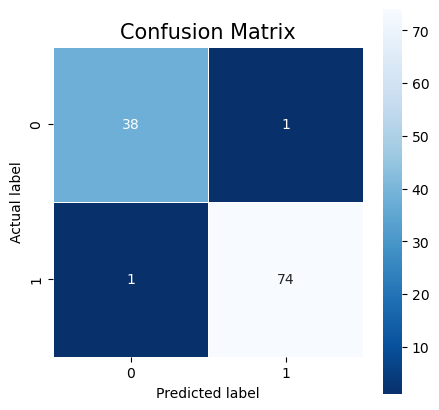

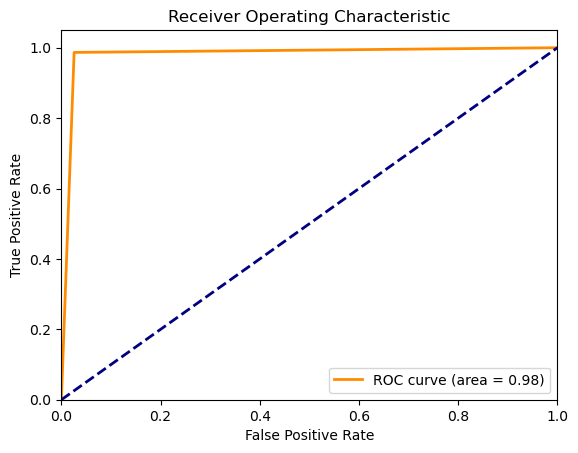

In [36]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns

# Calculate the confusion matrix
cm = confusion_matrix(test_data['target'], predictions)

# Plot the confusion matrix
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title('Confusion Matrix', size = 15);
plt.show()

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(test_data['target'], predictions)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

1. **Confusion Matrix**: A confusion matrix is a table that is often used to describe the performance of a classification model (or "classifier") on a set of test data for which the true values are known. It has four cells which represent the counts of:

   - True Positives (TP): The cases in which the model predicted "yes" (positive), and the truth is also "yes".
   - True Negatives (TN): The cases in which the model predicted "no" (negative), and the truth is also "no".
   - False Positives (FP): The cases in which the model predicted "yes", but the truth is "no". Also known as "Type I error".
   - False Negatives (FN): The cases in which the model predicted "no", but the truth is "yes". Also known as "Type II error".

2. **ROC Curve**: The Receiver Operating Characteristic (ROC) curve is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied. It plots the True Positive Rate (TPR) against the False Positive Rate (FPR) at various threshold settings. The TPR is also known as sensitivity, recall or probability of detection in machine learning. The FPR is also known as the fall-out or probability of false alarm and can be calculated as (1-specificity).

3. **AUC**: The Area Under the Curve (AUC) is the measure of the ability of a classifier to distinguish between classes and is used as a summary of the ROC curve. The higher the AUC, the better the performance of the model at distinguishing between the positive and negative classes.
